# Comparison of Python packages for hierarchical clustering

Example data has been downloaded from the open access <b>Human Gene Expression Atlas</b> and represents typical data bioinformaticians work with. 

It is <i>"Transcription profiling by array of brain in humans, chimpanzees and macaques, and brain, heart, kidney and liver in orangutans"</i> experiment in a tab-separated format. 

( http://www.ebi.ac.uk/gxa/experiment/E-TABM-84 )


In [15]:
%matplotlib inline 
import matplotlib.pylab

In [16]:
import numpy as np
#data = np.genfromtxt("data/ExpRawData-E-TABM-84-A-AFFY-44.tab",names=True,usecols=tuple(range(1,30)),dtype=float, delimiter="\t")
#data = np.genfromtxt('turkiye-student-evaluation_generic.csv', delimiter = ',');
data = np.recfromcsv('turkiye-student-evaluation_generic.csv', delimiter=',', filling_values=np.nan, case_sensitive=True, deletechars='', replace_space=' ');

In [17]:
print (len(data))
print (len(data.dtype.names))

5820
33


In [18]:
data_array = data.view((np.float, len(data.dtype.names)))
data_array = data_array.transpose()

Let's have a look at how our data actually looks like

In [19]:
print (data_array)

[[  4.94065646e-324   4.94065646e-324   4.94065646e-324 ...,
    1.48219694e-323   1.48219694e-323   1.48219694e-323]
 [  9.88131292e-324   9.88131292e-324   9.88131292e-324 ...,
    6.42285340e-323   6.42285340e-323   6.42285340e-323]
 [  4.94065646e-324   4.94065646e-324   4.94065646e-324 ...,
    4.94065646e-324   4.94065646e-324   4.94065646e-324]
 ..., 
 [  1.48219694e-323   1.48219694e-323   2.47032823e-323 ...,
    2.47032823e-323   4.94065646e-324   4.94065646e-324]
 [  1.48219694e-323   1.48219694e-323   2.47032823e-323 ...,
    2.47032823e-323   4.94065646e-324   4.94065646e-324]
 [  1.48219694e-323   1.48219694e-323   2.47032823e-323 ...,
    2.47032823e-323   4.94065646e-324   4.94065646e-324]]


## 1. Samples clustering using scipy

First, we'll implement the clustering using scipy modules

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram

In [21]:
data_dist = pdist(data_array) # computing the distance
data_link = linkage(data_dist) # computing the linkage

/home/kasloujr/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3193: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


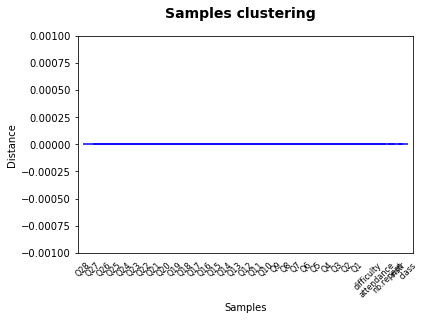

In [22]:
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);

Plotting a heatmap that many R users are used to is a tricky endevour in Python

/home/kasloujr/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  'left=%s, right=%s') % (left, right))


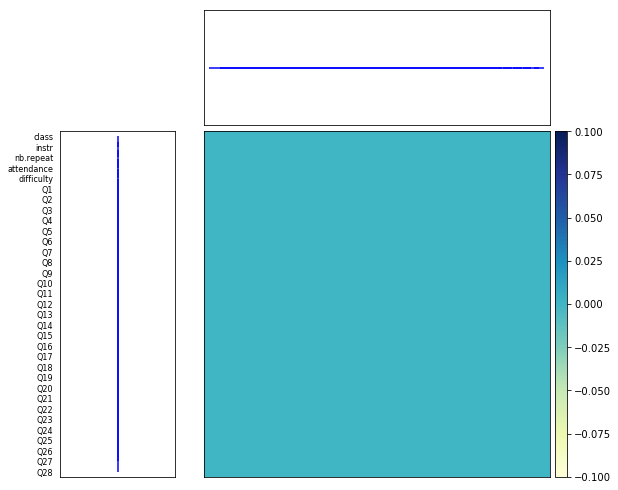

In [23]:
# Compute and plot first dendrogram.
fig = plt.figure(figsize=(8,8))
# x ywidth height
ax1 = fig.add_axes([0.05,0.1,0.2,0.6])
Y = linkage(data_dist, method='single')
Z1 = dendrogram(Y, orientation='right',labels=data.dtype.names) # adding/removing the axes
ax1.set_xticks([])

# Compute and plot second dendrogram.
ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
Z2 = dendrogram(Y)
ax2.set_xticks([])
ax2.set_yticks([])

#Compute and plot the heatmap
axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
idx1 = Z1['leaves']
idx2 = Z2['leaves']
D = squareform(data_dist)
D = D[idx1,:]
D = D[:,idx2]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot colorbar.
axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
plt.colorbar(im, cax=axcolor)

## 2. Fastcluster implementation is superior in memory usage

Learn more about the fastcluster module http://math.stanford.edu/~muellner/fastcluster.html?section=0

In [24]:
from fastcluster import *
%timeit data_link = linkage(data_array, method='single', metric='euclidean', preserve_input=True)
dendrogram(data_link,labels=data.dtype.names)
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.suptitle('Samples clustering', fontweight='bold', fontsize=14);
plt.show()

ImportError: No module named fastcluster

Naming conventions:
Before we start, as i know that it's easy to get lost, some naming conventions:

X samples (n x m array), aka data points or "singleton clusters"
n number of samples
m number of features
Z cluster linkage array (contains the hierarchical clustering information)
k number of clusters
So, let's go.

### set up

In [25]:
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
# some setting for this notebook to actually show the graphs inline, you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

### Generating Sample Data
You'll obviously not need this step to run the clustering if you have own data.

The only thing you need to make sure is that you convert your data into a matrix X with n samples and m features, so that X.shape == (n, m).

(150, 2)


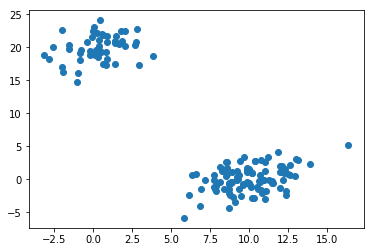

In [26]:
# generate two clusters: a with 100 points, b with 50:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print (X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

In [27]:
#Perform the Hierarchical Clustering
#Now that we have some very simple sample data, let's do the actual clustering on it:

#common linkage methods like 'single', 'complete', 'average', ... 
#and the different distance metrics like 'euclidean' (default), 'cityblock' aka Manhattan, 'hamming', 'cosine'..
# generate the linkage matrix
Z = linkage(X, 'ward')

common linkage methods like 'single', 'complete', 'average', ... and the different distance metrics like 'euclidean' (default), 'cityblock' aka Manhattan, 'hamming', 'cosine'..

Other common linkage methods like 'single', 'complete', 'average', ... and the different distance metrics like 'euclidean' (default), 'cityblock' aka Manhattan, 'hamming', 'cosine'... if you have the feeling that your data should not just be clustered to minimize the overall intra cluster variance in euclidean space. For example, you should have such a weird feeling with long (binary) feature vectors (e.g., word-vectors in text clustering).

Another thing you can and should definitely do is check the Cophenetic Correlation Coefficient of your clustering with help of the cophenet() function. This (very very briefly) compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances, which in our case is pretty close:

In [28]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.98001483875742679

In [29]:
Z[0]

array([ 52.     ,  53.     ,   0.04151,   2.     ])

No matter what method and metric you pick, the linkage() 
function will use that method and metric to calculate the 
distances of the clusters (starting with your n individual 
samples (data points) as singleton clusters)) 
and in each iteration will merge the two clusters 
which have the smallest distance according the selected 
method and metric. It will return an array of length 
$n - 1$ giving you information about the $n - 1$ cluster merges which it needs to pairwise merge n clusters. 
$Z[i]$ will tell us which clusters were merged in the $i-th$ iteration, let's take a look at the first two points that were merged:
We can see that ach row of the resulting array has the format [idx1, idx2, dist, sample_count].
In its first iteration the linkage algorithm decided to merge the two clusters (original samples here) with indices 52 and 53, as they only had a distance of 0.04151. This created a cluster with a total of 2 samples.

In [30]:
Z[1]

array([ 14.     ,  79.     ,   0.05914,   2.     ])

In the second iteration the algorithm decided to merge the clusters (original samples here as well) with indices 14 and 79, which had a distance of 0.04914. This again formed another cluster with a total of 2 samples.

The indices of the clusters until now correspond to our samples. Remember that we had a total of 150 samples, so indices 0 to 149. Let's have a look at the first 20 iterations:

In [31]:

Z[:20]

array([[  52.     ,   53.     ,    0.04151,    2.     ],
       [  14.     ,   79.     ,    0.05914,    2.     ],
       [  33.     ,   68.     ,    0.07107,    2.     ],
       [  17.     ,   73.     ,    0.07137,    2.     ],
       [   1.     ,    8.     ,    0.07543,    2.     ],
       [  85.     ,   95.     ,    0.10928,    2.     ],
       [ 108.     ,  131.     ,    0.11007,    2.     ],
       [   9.     ,   66.     ,    0.11302,    2.     ],
       [  15.     ,   69.     ,    0.11429,    2.     ],
       [  63.     ,   98.     ,    0.1212 ,    2.     ],
       [ 107.     ,  115.     ,    0.12167,    2.     ],
       [  65.     ,   74.     ,    0.1249 ,    2.     ],
       [  58.     ,   61.     ,    0.14028,    2.     ],
       [  62.     ,  152.     ,    0.1726 ,    3.     ],
       [  41.     ,  158.     ,    0.1779 ,    3.     ],
       [  10.     ,   83.     ,    0.18635,    2.     ],
       [ 114.     ,  139.     ,    0.20419,    2.     ],
       [  39.     ,   88.     ,

We can observe that until iteration 13 the algorithm only directly merged original samples. We can also observe the monotonic increase of the distance. In iteration 13 the algorithm decided to merge cluster indices 62 with 152. If you paid attention the 152 should astonish you as we only have original sample indices 0 to 149 for our 150 samples. All indices $idx >= len(X)$ actually refer to the cluster formed in $Z[idx - len(X)]$.

This means that while idx 149 corresponds to X[149] that idx 150 corresponds to the cluster formed in Z[0], idx 151 to Z[1], 152 to Z[2], ...

Hence, the merge iteration 13 merged sample 62 to our samples 33 and 68 that were previously merged in iteration 2 (152 - 2).

Let's check out the points coordinates to see if this makes sense:

In [32]:
X[[33, 68, 62]]

array([[ 9.83913, -0.4873 ],
       [ 9.89349, -0.44152],
       [ 9.97793, -0.56383]])

Seems pretty close, but let's plot the points again and highlight them:

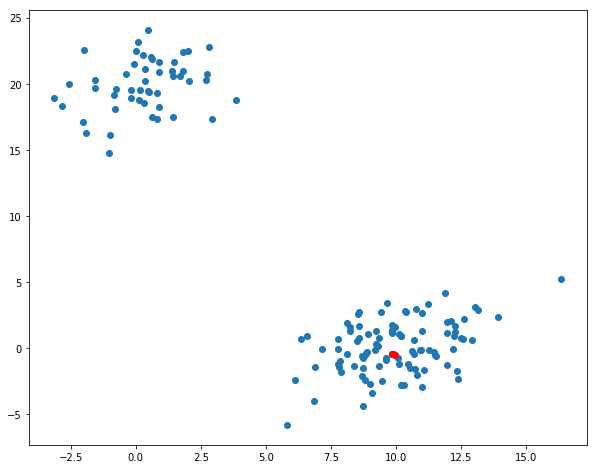

In [33]:
idxs = [33, 68, 62]
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])  # plot all points
plt.scatter(X[idxs,0], X[idxs,1], c='r')  # plot interesting points in red again
plt.show()

Plotting a Dendrogram
A dendrogram is a visualization in form of a tree showing the order and distances of merges during the hierarchical clustering.

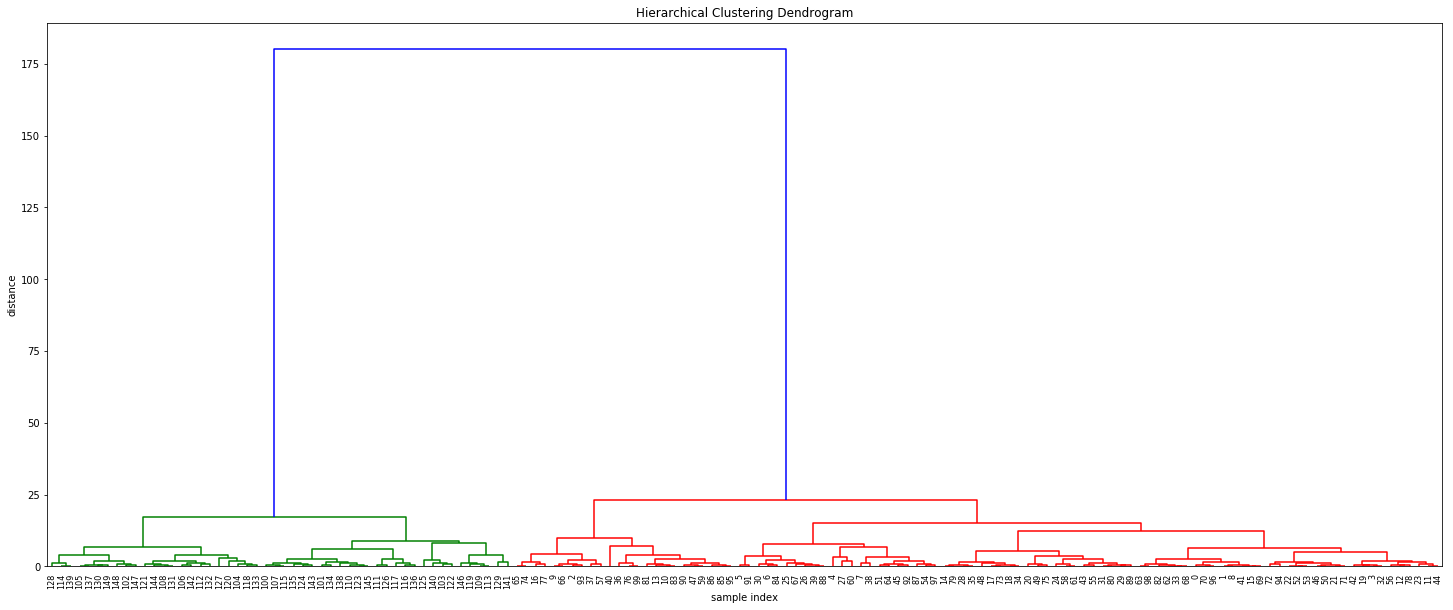

In [34]:

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

(right click and "View Image" to see full resolution)

If this is the first time you see a dendrogram, it's probably quite confusing, so let's take this apart...

On the x axis you see labels. If you don't specify anything else they are the indices of your samples in X.
On the y axis you see the distances (of the 'ward' method in our case).
Starting from each label at the bottom, you can see a vertical line up to a horizontal line. The height of that horizontal line tells you about the distance at which this label was merged into another label or cluster. You can find that other cluster by following the other vertical line down again. If you don't encounter another horizontal line, it was just merged with the other label you reach, otherwise it was merged into another cluster that was formed earlier.

Summarizing:

horizontal lines are cluster merges
vertical lines tell you which clusters/labels were part of merge forming that new cluster
heights of the horizontal lines tell you about the distance that needed to be "bridged" to form the new cluster
You can also see that from distances > 25 up there's a huge jump of the distance to the final merge at a distance of approx. 180. Let's have a look at the distances of the last 4 merges:

In [35]:
Z[-4:,2]

array([  15.11533,   17.11527,   23.12199,  180.27043])

Such distance jumps / gaps in the dendrogram are pretty interesting for us. They indicate that something is merged here, that maybe just shouldn't be merged. In other words: maybe the things that were merged here really don't belong to the same cluster, telling us that maybe there's just 2 clusters here.

Looking at indices in the above dendrogram also shows us that the green cluster only has indices >= 100, while the red one only has such < 100. This is a good thing as it shows that the algorithm re-discovered the two classes in our toy example.

In case you're wondering about where the colors come from, you might want to have a look at the color_threshold argument of dendrogram(), which as not specified automagically picked a distance cut-off value of 70 % of the final merge and then colored the first clusters below that in individual colors.

Dendrogram Truncation
As you might have noticed, the above is pretty big for 150 samples already and you probably have way more in real scenarios, so let me spend a few seconds on highlighting some other features of the dendrogram() function:

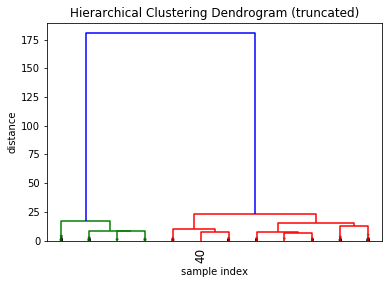

In [36]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

The above shows a truncated dendrogram, which only shows the last p=12 out of our 149 merges.

First thing you should notice are that most labels are missing. This is because except for X[40] all other samples were already merged into clusters before the last 12 merges.

The parameter show_contracted allows us to draw black dots at the heights of those previous cluster merges, so we can still spot gaps even if we don't want to clutter the whole visualization. In our example we can see that the dots are all at pretty small distances when compared to the huge last merge at a distance of 180, telling us that we probably didn't miss much there.

As it's kind of hard to keep track of the cluster sizes just by the dots, dendrogram() will by default also print the cluster sizes in brackets () if a cluster was truncated:

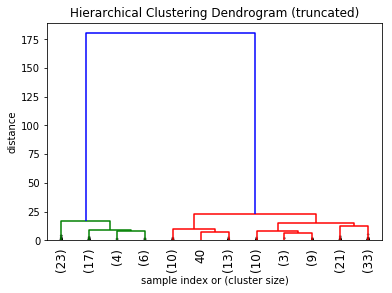

In [37]:

plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

We can now see that the right most cluster already consisted of 33 samples before the last 12 merges.

Eye Candy
Even though this already makes for quite a nice visualization, we can pimp it even more by also annotating the distances inside the dendrogram by using some of the useful return values dendrogram():

In [38]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

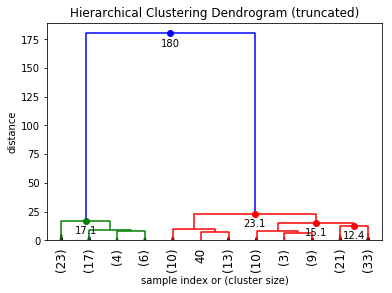

In [39]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

Selecting a Distance Cut-Off aka Determining the Number of Clusters
As explained above already, a huge jump in distance is typically what we're interested in if we want to argue for a certain number of clusters. If you have the chance to do this manually, i'd always opt for that, as it allows you to gain some insights into your data and to perform some sanity checks on the edge cases. In our case i'd probably just say that our cut-off is 50, as the jump is pretty obvious:

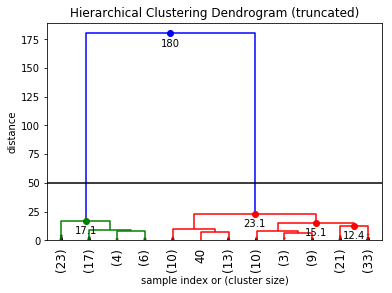

In [40]:
# set cut-off to 50
max_d = 50  # max_d as in max_distance
#Let's visualize this in the dendrogram as a cut-off line:

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,  # plot a horizontal cut-off line
)
plt.show()

As we can see, we ("surprisingly") have two clusters at this cut-off.

In general for a chosen cut-off value max_d you can always simply count the number of intersections with vertical lines of the dendrogram to get the number of formed clusters. Say we choose a cut-off of max_d = 16, we'd get 4 final clusters:

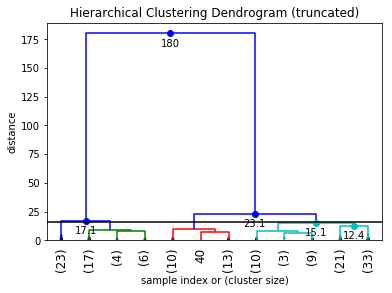

In [41]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=16,
)
plt.show()

Automated Cut-Off Selection (or why you shouldn't rely on this)
Now while this manual selection of a cut-off value offers a lot of benefits when it comes to checking for a meaningful clustering and cut-off, there are cases in which you want to automate this.

The problem again is that there is no golden method to pick the number of clusters for all cases (which is why i think the investigative & backtesting manual method is preferable). Wikipedia lists a couple of common methods. Reading this, you should realize how different the approaches and how vague their descriptions are.

I honestly think it's a really bad idea to just use any of those methods, unless you know the data you're working on really really well.

Inconsistency Method
For example, let's have a look at the "inconsistency" method, which seems to be one of the defaults for the fcluster() function in scipy.

The question driving the inconsistency method is "what makes a distance jump a jump?". It answers this by comparing each cluster merge's height h to the average avg and normalizing it by the standard deviation std formed over the depth previous levels:

inconsistency=h−avgstd
The following shows a matrix of the avg, std, count, inconsistency for each of the last 10 merges of our hierarchical clustering with depth = 5

In [42]:
from scipy.cluster.hierarchy import inconsistent

depth = 5
incons = inconsistent(Z, depth)
incons[-10:]

array([[  1.80875,   2.17062,  10.     ,   2.44277],
       [  2.31732,   2.19649,  16.     ,   2.52742],
       [  2.24512,   2.44225,   9.     ,   2.37659],
       [  2.30462,   2.44191,  21.     ,   2.63875],
       [  2.20673,   2.68378,  17.     ,   2.84582],
       [  1.95309,   2.581  ,  29.     ,   4.05821],
       [  3.46173,   3.53736,  28.     ,   3.29444],
       [  3.15857,   3.54836,  28.     ,   3.93328],
       [  4.9021 ,   5.10302,  28.     ,   3.57042],
       [ 12.122  ,  32.15468,  30.     ,   5.22936]])

Now you might be tempted to say "yay, let's just pick 5" as a limit in the inconsistencies, but look at what happens if we set depth to 3 instead:

In [43]:
depth = 3
incons = inconsistent(Z, depth)
incons[-10:]

array([[  3.63778,   2.55561,   4.     ,   1.35908],
       [  3.89767,   2.57216,   7.     ,   1.54388],
       [  3.05886,   2.66707,   6.     ,   1.87115],
       [  4.92746,   2.7326 ,   7.     ,   1.39822],
       [  4.76943,   3.16277,   6.     ,   1.60456],
       [  5.27288,   3.56605,   7.     ,   2.00627],
       [  8.22057,   4.07583,   7.     ,   1.69162],
       [  7.83287,   4.46681,   7.     ,   2.07808],
       [ 11.38091,   6.2943 ,   7.     ,   1.86535],
       [ 37.25845,  63.31539,   7.     ,   2.25872]])

Oups! This should make you realize that the inconsistency values heavily depend on the depth of the tree you calculate the averages over.

Another problem in its calculation is that the previous d levels' heights aren't normally distributed, but expected to increase, so you can't really just treat the current level as an "outlier" of a normal distribution, as it's expected to be bigger.

Elbow Method
Another thing you might see out there is a variant of the "elbow method". It tries to find the clustering step where the acceleration of distance growth is the biggest (the "strongest elbow" of the blue line graph below, which is the highest value of the green graph below):

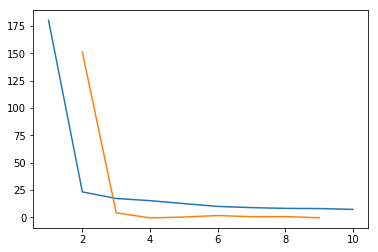

('clusters:', 2)


In [44]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

While this works nicely in our simplistic example (the green line takes its maximum for k=2), it's pretty flawed as well.

One issue of this method has to do with the way an "elbow" is defined: you need at least a right and a left point, which implies that this method will never be able to tell you that all your data is in one single cluster only.

Another problem with this variant lies in the np.diff(Z[:, 2], 2) though. The order of the distances in Z[:, 2] isn't properly reflecting the order of merges within one branch of the tree. In other words: there is no guarantee that the distance of Z[i] is contained in the branch of Z[i+1]. By simply computing the np.diff(Z[:, 2], 2) we assume that this doesn't matter and just compare distance jumps from different branches of our merge tree.

If you still don't want to believe this, let's just construct another simplistic example but this time with very different variances in the different clusters:

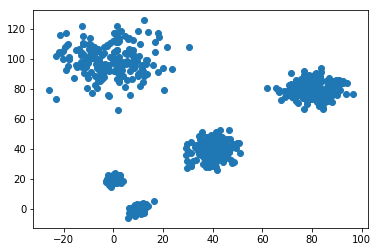

In [45]:
c = np.random.multivariate_normal([40, 40], [[20, 1], [1, 30]], size=[200,])
d = np.random.multivariate_normal([80, 80], [[30, 1], [1, 30]], size=[200,])
e = np.random.multivariate_normal([0, 100], [[100, 1], [1, 100]], size=[200,])
X2 = np.concatenate((X, c, d, e),)
plt.scatter(X2[:,0], X2[:,1])
plt.show()

As you can see we have 5 clusters now, but they have increasing variances... let's have a look at the dendrogram again and how you can use it to spot the problem:

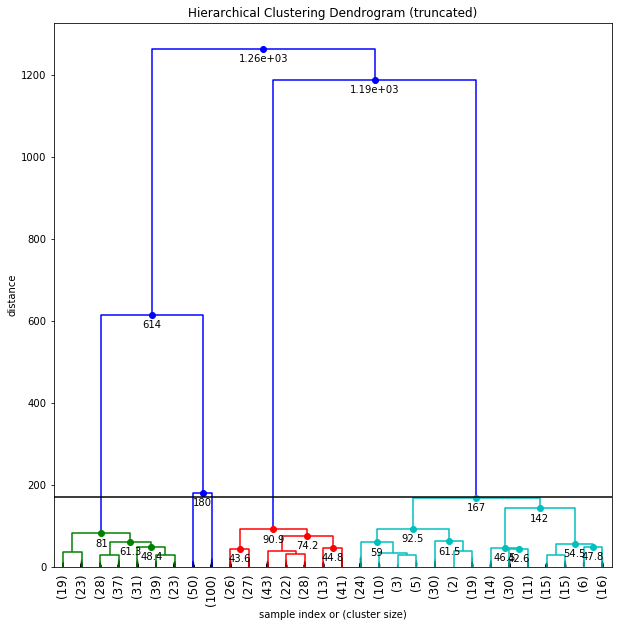

In [46]:
Z2 = linkage(X2, 'ward')
plt.figure(figsize=(10,10))
fancy_dendrogram(
    Z2,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=40,
    max_d=170,
)
plt.show()

When looking at a dendrogram like this and trying to put a cut-off line somewhere, you should notice the very different distributions of merge distances below that cut-off line. Compare the distribution in the cyan cluster to the red, green or even two blue clusters that have even been truncated away. In the cyan cluster below the cut-off we don't really have any discontinuity of merge distances up to very close to the cut-off line. The two blue clusters on the other hand are each merged below a distance of 25, and have a gap of > 155 to our cut-off line.

The variant of the "elbow" method will incorrectly see the jump from 167 to 180 as minimal and tell us we have 4 clusters:

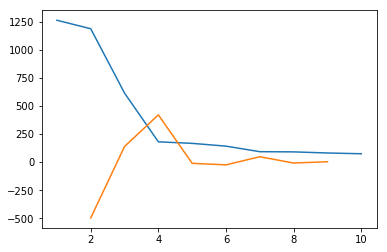

('clusters:', 4)


In [47]:
last = Z2[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

The same happens with the inconsistency metric:

In [48]:
print (inconsistent(Z2, 5)[-10:])

[[  13.99222   15.56656   30.         3.86585]
 [  16.73941   18.5639    30.         3.45983]
 [  19.05945   20.53211   31.         3.49953]
 [  19.25574   20.82658   29.         3.51907]
 [  21.36116   26.7766    30.         4.50256]
 [  36.58101   37.08602   31.         3.50761]
 [  12.122     32.15468   30.         5.22936]
 [  42.6137   111.38577   31.         5.13038]
 [  81.75199  208.31582   31.         5.30448]
 [ 147.25602  307.95701   31.         3.6215 ]]


I hope you can now understand why i'm warning against blindly using any of those methods on a dataset you know nothing about. They can give you some indication, but you should always go back in and check if the results make sense, for example with a dendrogram which is a great tool for that (especially if you have higher dimensional data that you can't simply visualize anymore).

Retrieve the Clusters
Now, let's finally have a look at how to retrieve the clusters, for different ways of determining k. We can use the fcluster function.

Knowing max_d:
Let's say we determined the max distance with help of a dendrogram, then we can do the following to get the cluster id for each of our samples:

In [49]:
from scipy.cluster.hierarchy import fcluster
max_d = 50
clusters = fcluster(Z, max_d, criterion='distance')
clusters

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Knowing k:
Another way starting from the dendrogram is to say "i can see i have k=2" clusters. You can then use:



In [50]:
k=2
fcluster(Z, k, criterion='maxclust')

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Using the Inconsistency Method (default):
If you're really sure you want to use the inconsistency method to determine the number of clusters in your dataset, you can use the default criterion of fcluster() and hope you picked the correct values:

In [51]:
from scipy.cluster.hierarchy import fcluster
fcluster(Z, 8, depth=10)

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Visualizing Your Clusters
If you're lucky enough and your data is very low dimensional, you can actually visualize the resulting clusters very easily:

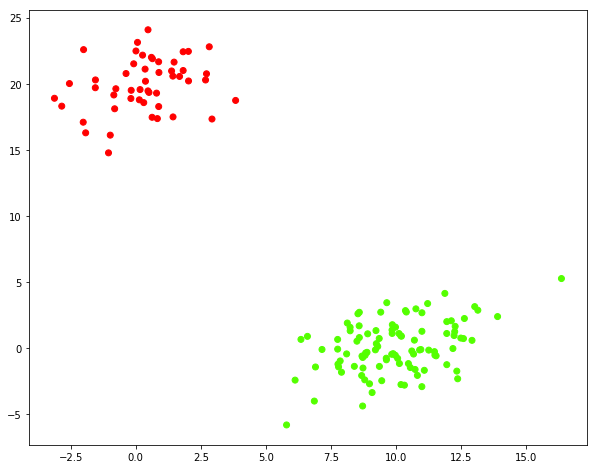

In [52]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

### Implement this notebook for a data from https://archive.ics.uci.edu/ml/datasets.html

Study the tutorial

https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/